# Part 1

Revisit the Jupyter notebook from the previous self study session; there we implemented a simple neural network using functionality from numpy and PyTorch. 

### Exercise: 
* Modify the code by introducing regularization (L1 and/or L2). 
* How does the regularization affect the neural network results and the weights being learned? Try also experimenting with different weights for the regularization term.

In [27]:
import torch
from pathlib import Path
import requests
from matplotlib import pyplot
import matplotlib.pyplot as plt
import numpy as np
import pickle
import gzip
from scipy import signal
from torchvision import datasets, transforms

# Part 2

## Exercise

In this exercise, the intention is to get a bit more handson experience with the convolution operator

The MNIST database consists of grey scale images of handwritten digits. Each image is of size $28\times 28$; see figure below for an illustration. The data set is divided into a training set, validation set, and test set consisting of $50000$, $10000$, and $10000$ images, respectively; in all data sets the images are labeled with the correct digits. If interested, you can find more information about the MNIST data set at http://yann.lecun.com/exdb/mnist/, including accuracy results for various machine learning methods.

![MNIST DATA](MNIST-dataset.png)

First we download the dataset and unpackage it.

In [25]:
DATA_PATH = Path("data")
PATH = DATA_PATH / "mnist"

PATH.mkdir(parents=True, exist_ok=True)

URL = "https://github.com/pytorch/tutorials/raw/master/_static/"
#URL = "http://deeplearning.net/data/mnist/"
FILENAME = "mnist.pkl.gz"

if not (PATH / FILENAME).exists():
        content = requests.get(URL + FILENAME).content
        (PATH / FILENAME).open("wb").write(content)

We then extract the data and store it numpy arrays: x_train, y_train, x_valid, y_valid, x_test, y_test 

In [29]:
batch_size = 64
train_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=True, download=True,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=batch_size, shuffle=True)

with gzip.open((PATH / FILENAME).as_posix(), "rb") as f:
        ((x_train, y_train), (x_valid, y_valid), (x_test, y_test)) = pickle.load(f, encoding="latin-1")

Check the shape of the x_valid holding the validation data

The images are stored in rows of length $784$, hence to display the images we need to reshape them to $28\times 28$.

Batch dimension (digit): torch.Size([64, 1, 28, 28])
Batch dimension (target): torch.Size([64])
Target: 5 with shape torch.Size([])


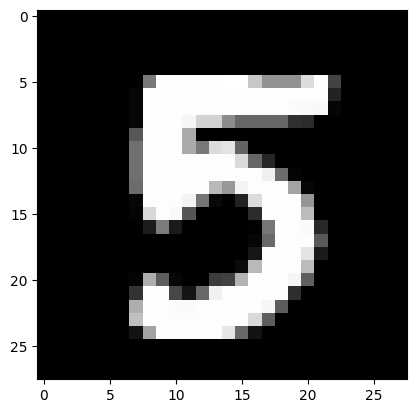

In [30]:
batch = next(iter(train_loader))
print(f"Batch dimension (digit): {batch[0].shape}")
print(f"Batch dimension (target): {batch[1].shape}")
digit_batch = batch[0]
img = digit_batch[0,:]
pyplot.imshow(img.reshape((28, 28)), cmap="gray")
print(f"Target: {batch[1][0]} with shape {batch[1][0].shape}")

torch.Size([64, 1, 28, 28])


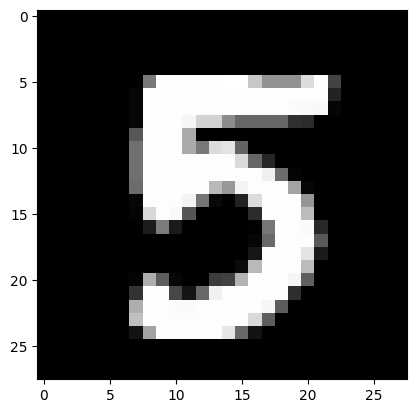

In [36]:
img = digit_batch[0,:]
pyplot.imshow(img.reshape((28, 28)), cmap="gray")
print(batch[0].shape)

We can also convert the image into black and white

(50000, 784)


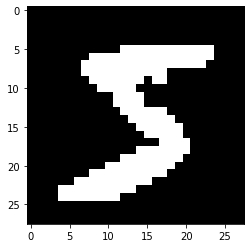

In [5]:
bw = np.array(x_train[0]>0, dtype=int)
pyplot.imshow(bw.reshape((28, 28)), cmap="gray")
print(x_train.shape)

We can do 2D convolutions using the function convolve2d from scipy.signal. Below is an example, where we apply the convolution operator from Slide 29 to the image above.

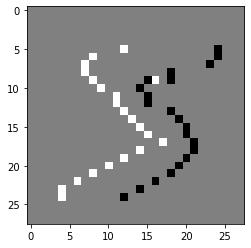

In [6]:
kernel = np.array([[1,-1]])
res = signal.convolve2d(bw.reshape((28, 28)),kernel, 'same')
pyplot.imshow(res.reshape((28, 28)), cmap="gray")

## Exercise:

* Experiment with different kernels to get an impression of the convolution operator. You may find some inspiration for kernels [here](https://en.wikipedia.org/wiki/Kernel_(image_processing)). If you feel adventuruous, you are most welcome to play around with other images. 
* Try also taking a closer look at the numerical values being produced to verify your understanding.

# Part 3

During the last self study session we only made limited use of PyTorch’s functionality for constructing neural networks (basically only using it for calculating gradients). In the self study session below, we will take advantage of much more of its functionality. Specifically, we will start experimenting with convolutional neural networks.

The convolution constructs in PyTorch rely on the torch.nn module provided by PyTorch. A short introduction to this module and how to define neural networks in PyTorch can be found at:
* https://pytorch.org/tutorials/beginner/blitz/neural_networks_tutorial.html#sphx-glr-beginner-blitz-neural-networks-tutorial-py
* https://pytorch.org/tutorials/beginner/nn_tutorial.html

If you have finished with the previous exercises, you can start preparing for the self study session by going through these tutorials. The former tutorial is part of a general tutorial package to PyTorch, which can be found at:
* https://pytorch.org/tutorials/beginner/deep_learning_60min_blitz.html
this also includes a nice introduction to tensors in PyTorch.

# Self study 2

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
from matplotlib import pyplot
import numpy as np

## Loading the data

As last time we will be working with the MNIST data set: The MNIST database consists of grey scale images of handwritten digits. Each image is of size $28\times 28$; see figure below for an illustration. The data set is divided into a training set consisting of $60000$ images and a test set with $10000$ images; in both
data sets the images are labeled with the correct digits. If interested you can find more information about the MNIST data set at http://yann.lecun.com/exdb/mnist/, including accuracy results for various machine learning methods.

![MNIST DATA](MNIST-dataset.png)

For this self study, we will be a bit more careful with our data. Specifically, we will divide the data into a training, validation, and test, and use the training and validation set for model learning (in the previous self study we did not have a validation set). 

The data set is created by setting aside a randomly chosen subset of the data, where the splitting point is found using the help function *split_indicies* below.

In [ ]:
def split_indicies(n, val_pct):
    # Size of validation set
    n_val = int(n*val_pct)
    # Random permutation
    idxs = np.random.permutation(n)
    # Return first indexes for the validation set
    return idxs[n_val:], idxs[:n_val]

# Load the data
train_dataset = datasets.MNIST('../data', train=True, download=False,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ]))

# Get the indicies for the training data and test data (the validation set will consists of 20% of the data)
train_idxs, val_idxs = split_indicies(len(train_dataset), 0.2)

# Define samplers (used by Dataloader) to the two sets of indicies
train_sampler = SubsetRandomSampler(train_idxs)
val_sampler = SubsetRandomSampler(val_idxs)

# Specify data loaders for our training and test set (same functionality as in the previous self study)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=train_sampler)
val_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, sampler=val_sampler)

print(f"Number of training examples: {len(train_idxs)}")
print(f"Number of validation examples: {len(val_idxs)}")

The test set is loaded in the usual fashion

In [ ]:
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('../data', train=False, transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])),
        batch_size=64, shuffle=True)

## Specifying the model

When using the _torch.nn_ for specifying our model we subclass the _nn.Module_. The model thus holds all the parameters of the model (see the _init_ function) as well as a specification of the forward step. We don't have to keep track of the backward pass, as PyTorch handles this for us.

In [ ]:
class MNIST_CNN(nn.Module):

    def __init__(self):
        super().__init__()

        # Define a convolution operator with 1 input channel, 15 output channels and a kernel size of 5x5
        self.conv1 = nn.Conv2d(1, 15, 5)
        # Since we are not doing padding (see Lecture 2, Slide 38) the width of the following layer is reduced; for
        # each channel the resulting dimension is 24x24. We feed the resulting representation through a linear 
        # layer, giving 10 values as output - one for each digit.
        self.fc = nn.Linear(15 * 24 * 24, 10)
        self.out = None

    def forward(self, xb):

        # Reshape the input tensor; '-1' indicates that PyTorch will fill-in this 
        # dimension, whereas the '1' indicates that we only have one color channel. 
        xb = xb.view(-1, 1, 28, 28)
        # Apply convolution and pass the result through a ReLU function
        xb = F.relu(self.conv1(xb))
        # Reshape the representation
        xb = xb.view(-1, 15*24*24)
        # Apply the linear layer
        xb = self.fc(xb)
        # and set the result as the output. Note that we don't take a softmax as this is handled internally in the 
        # loss function defined below.
        self.out = xb

        return xb

## Learning and evaluating the model

For learning the model, we will use the following function which performs one iteration over the training data. The function also takes an _epoch_ argument, but this is only used for reporting on the learning progress

In [ ]:
def train(model, train_loader, loss_fn, epoch):
    # Tell PyTorch that this function is part of the training
    model.train()

    # As optimizer we use stochastic gradient descent as defined by PyTorch. PyTorch also includes a variety 
    # of other optimizers 
    learning_rate = 0.01
    opt = torch.optim.SGD(model.parameters(), lr=learning_rate)

    # Iterate over the training set, one batch at the time, as in the previous self sudy
    for batch_idx, (data, target) in enumerate(train_loader):
        # Get the prediction
        y_pred = model(data)
        
        # Remember to zero the gradients so that they don't accumulate
        opt.zero_grad()

        # Calculate the loss and and the gradients  
        loss = loss_fn(y_pred, target)
        loss.backward()

        # Optimize the parameters by taking one 'step' with the optimizer
        opt.step()

        # For every 10th batch we output a bit of info
        if batch_idx % 10 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.sampler),
                       100. * batch_idx * len(data) / len(train_loader.sampler), loss.item()))

In the end, we also want to validate our model. To do this we define the function below, which takes a data_loader (either the validation or test set) and reports the model's accuracy and loss on that data set.

In [ ]:
def test_model(model, data_loader, loss_fn):
    # Tell PyTorch that we are performing evaluation
    model.eval()
    
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in data_loader:
            output = model(data)
            test_loss += loss_fn(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(data_loader.dataset)

    print('\nTest/validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(data_loader.sampler),
        100. * correct / len(data_loader.sampler)))

## A couple of helper functions

Learning a deep neural network can be time consuming, and it might therefore be nice to be able to save and load previously learned models (see also https://pytorch.org/tutorials/beginner/saving_loading_models.html).

In [ ]:
def save_model(file_name, model):
    torch.save(model, file_name)

def load_model(file_name):
    model = torch.load(file_name)
    model.eval()
    return model

## Wrapping things up

Finally, we will do the actual learning of the model.

In [ ]:
# The number of passes that will be made over the training set
num_epochs = 2
# torch.nn defines several useful loss-functions, which we will take advantage of here (see Lecture 1, Slide 11, Log-loss).
loss_fn = nn.CrossEntropyLoss()

In [ ]:
# Instantiate the model class
model = MNIST_CNN()
# and get some information about the structure
print('Model structure:')
print(model)

### Iterate over the data set

We iterate over the data set for *num_epochs* number of iterations. At each iteration we also calculate the loss/accuracy on the validation set.

In [ ]:
for i in range(num_epochs):
    train(model, train_loader, loss_fn, i)
    # Evaluate the model on the test set
    test_model(model, val_loader, loss_fn)

After learning we evaluate the model on the _test set_ and save the resulting structure.

In [ ]:
# Evaluate the model on the test set
test_model(model, test_loader, loss_fn)
# Save the model
save_model('conv.pt', model)

## Exercises

1. Familiarize yourself with the code above and consult the PyTorch documentation when needed.
2. Experiment with different NN architectures (also varying the convolutional parameters: size, stride, padding, etc) and observe the effect wrt. the loss/accuracy on the training and validation dataset (training, validation). Note that when adding new layers (including dropout [Lecture 2, Slide 13], pooling, etc.) you need to make sure that the dimensionality of the layers match up. **IMPORTANT:** ignore the test set at this stage (i.e., comment out the relevant lines above) so that the results for the test set do not influence your model choice.
3. In the model above we use a simple gradient descent learning scheme. Try other types of optimizers (see https://pytorch.org/docs/stable/optim.html) and analyze the effect.
4. If you feel adventurous, try investigating some of the other datasets that come prepacakged with PyTorch (see https://pytorch.org/vision/0.8/datasets.html). For instnce, for FashionMNIST you only need to change the dataloader from datasets.MNIST to datasets.FashionMNIST.